
## GCN with different weight perturbation methods on linear separable dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter
from torchvision import datasets, transforms
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import seaborn
import matplotlib.patches as patches
from scipy.spatial import HalfspaceIntersection
from scipy.stats import norm as gaussian
from deeprobust.graph.defense import GCN
import numpy as np
from sklearn import cluster, datasets
from itertools import cycle, islice
from sklearn.model_selection import train_test_split
import sklearn
torch.cuda.set_device(1) 
device = torch.device("cuda")

%matplotlib inline
seaborn.set(font_scale=2)
seaborn.set_style("white")


## Date generation

In [2]:
def get_data(number, data_type):
    if data_type == "rings":
        X,y = datasets.make_circles(n_samples=number, factor=.5, noise=.2)
        X=(X-np.min(X))/(np.max(X)-np.min(X))
#         print(len(data_set))
    elif data_type == "moons":
        X,y = datasets.make_moons(n_samples=number, noise=.2)
        X=(X-np.min(X))/(np.max(X)-np.min(X))
    elif data_type == "linear":
        X = np.random.uniform(size=(number,2))
        y = np.array(X[:, 0]<0.5,dtype=np.long)

    elif data_type == "gaussian":
        x1 = np.random.multivariate_normal([0,0], [[0.7,0],[0,0.7]],int(number/2))
        x2 = np.random.multivariate_normal([1,1], [[0.7,0],[0,0.7]], int(number/2))
        y1 = np.zeros(int(number/2))
        y2 = np.zeros(int(number/2))+1
        X = np.concatenate((x1,x2),axis=0)
        X=(X-np.min(X))/(np.max(X)-np.min(X))
        y = np.concatenate((y1,y2),axis=0)
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)
    knn.fit(X,y)
    graph = knn.kneighbors_graph(X=X, n_neighbors=3, mode='connectivity')
    graph = (graph+graph.T)/2
    
    idx = np.arange(number)
    train_size = 0.2
    test_size = 0.8
    idx_train_val, idx_test = train_test_split(idx,
                                           random_state=None,
                                           train_size=train_size,
                                           test_size=test_size,
                                           stratify=y)
    idx_train,idx_val = train_test_split(idx_train_val,
                                           random_state=None,
                                           train_size=0.5,
                                           test_size=0.5,
                                           stratify=y[idx_train_val])
    return graph,X,y,idx_train,idx_val, idx_test,knn

In [3]:
graph,X,y,idx_train,idx_val, idx_test,knn = get_data(200,'linear')

/tmp/ipykernel_12964/3713087759.py:11: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(X[:, 0]<0.5,dtype=np.long)


## Heatmap plot

In [4]:
def plot_original_net(net,knn):
    result = torch.softmax(net.testlogit[idx_test],dim = 1).detach().cpu().numpy()
    X_test  = X[idx_test]
    y_test  = y[idx_test]
    clo = ((result[:,0]-0.5)/0.5)
    plt.figure(figsize=(5,5))
    edc = []
    for i in y_test:
        if i==0:
            edc.append('r')
        else:
            edc.append('b')
#     colorsmap = plt.cm.coolwarm(clo)
    maxx = max(abs(clo))
#     print(maxx)
    c = plt.scatter([0,0],[0,0],c = [-maxx,maxx],cmap="coolwarm",s=0.01)
    plt.scatter(X_test[:,0], X_test[:,1], c=clo, cmap="coolwarm", s=70,facecolors='none',edgecolors = edc,linewidths=1)
    
    for m in idx_test:
        idxxx = knn.kneighbors(X[m:m+1], n_neighbors=3, return_distance=False)[0]
        for i in idxxx:
            if i in idx_test:
                plt.plot([X[m,0],X[i,0]],[X[m,1],X[i,1]],linewidth=0.9,color = 'grey')
        
    plt.colorbar(c) 

## Training

### Vanilla GCN

In [5]:
gcnn = GCN(nfeat=X.shape[1], nclass=2, nhid=64, device=device,nolast=False)
gcnn = gcnn.to(device)
proxy = GCN(nfeat=X.shape[1], nclass=2, nhid=64, device=device,nolast=False)
proxy = proxy.to(device)

gcnn.fit(X, graph, y, idx_train,idx_val=idx_val,verbose=False,
             train_iters = 200,idx_test = idx_test,seed=0)
gcnn.test(idx_test)

Test set results: loss= 0.0377 accuracy= 0.9875


0.9875

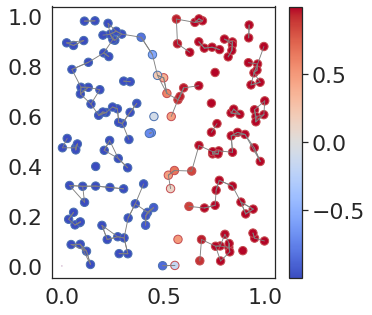

In [6]:
plot_original_net(gcnn,knn)

### GCN + AWP

In [7]:
gcn = GCN(nfeat=X.shape[1], nclass=2, nhid=64, device=device,nolast=False)
gcn = gcn.to(device)
proxy = GCN(nfeat=X.shape[1], nclass=2, nhid=64, device=device,nolast=False)
proxy = proxy.to(device)

gcn.fit_mp(X, graph, y, idx_train,proxy=proxy,idx_val=idx_val,verbose=False,
             awp_weight = 1, awp_gamma = 3,train_iters = 200,idx_test = idx_test,seed=0,awp_step = 1)
gcn.test(idx_test)

Test set results: loss= 0.6947 accuracy= 0.5125


0.5125000000000001

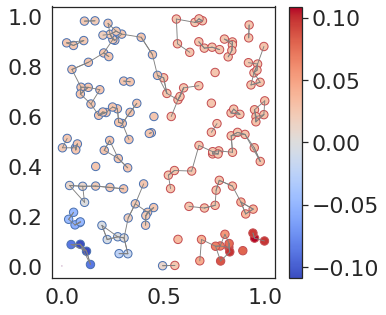

In [8]:
plot_original_net(gcn,knn)

### GCN + Truncated AWP

In [9]:
gcnt = GCN(nfeat=X.shape[1], nclass=2, nhid=64, device=device,nolast=True)
gcnt = gcnt.to(device)
proxy = GCN(nfeat=X.shape[1], nclass=2, nhid=64, device=device,nolast=True)
proxy = proxy.to(device)

gcnt.fit_mp(X, graph, y, idx_train,proxy=proxy,idx_val=idx_val,verbose=False,
             awp_weight = 1, awp_gamma = 3,train_iters = 200,idx_test = idx_test,seed=0,awp_step = 1)
gcnt.test(idx_test)

Test set results: loss= 0.3904 accuracy= 0.8875


0.8875000000000001

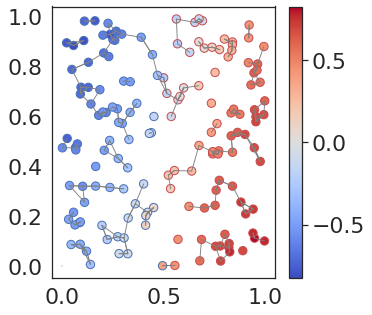

In [10]:
plot_original_net(gcnt,knn)

### GCN + Weighted AWP

In [11]:
gcnw = GCN(nfeat=X.shape[1], nclass=2, nhid=64, device=device,nolast=False)
gcnw = gcn.to(device)
proxy = GCN(nfeat=X.shape[1], nclass=2, nhid=64, device=device,nolast=False)
proxy = proxy.to(device)

gcnw.fit_mp(X, graph, y, idx_train,proxy=proxy,idx_val=idx_val,verbose=False,
             awp_weight = 0.5, awp_gamma = 3,train_iters = 200,idx_test = idx_test,seed=0,awp_step = 1)
gcnw.test(idx_test)

Test set results: loss= 0.3216 accuracy= 0.9625


0.9625

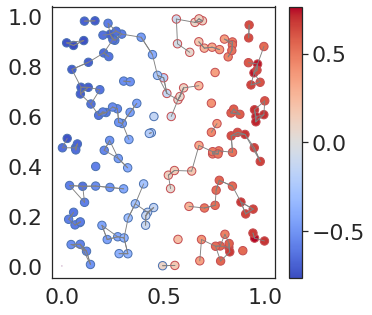

In [12]:
plot_original_net(gcnw,knn)